# Sentiment Analysis for Amazon Reviews with NLP

## Data Wrangling & EDA for Sentiment Analysis

In [1]:
#Import Libraries and Load Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset (update path if needed)
df = pd.read_csv("amazon_reviews.csv")

df.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


# Understanding the Data

In [2]:
df.info()
df.describe()
df.isnull().sum()
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


np.int64(0)

Data Overview: 4915 rows, 12 columns.

Missing Values: One missing reviewerName and one missing reviewText.

Duplicates: No duplicate rows found.

# Clean Missing and Duplicate Data

In [3]:
# Drop duplicates
df = df.drop_duplicates()

# Drop rows where review text is missing
df = df.dropna(subset=['reviewText'])


# Data Wrangling for NLP


In [4]:
nltk.download('punkt_tab')

#Text Cleaning + Tokenization + Stopwords + Lemmatization
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()                                 # lowercase
    text = re.sub(r"http\S+|www\S+","", text)           # remove links
    text = re.sub(r"[^a-zA-Z\s]", "", text)             # remove punctuation & numbers
    tokens = word_tokenize(text)                        # tokenize
    tokens = [w for w in tokens if w not in stop_words] # remove stopwords
    tokens = [lemmatizer.lemmatize(w) for w in tokens]  # lemmatize
    return " ".join(tokens)

df["clean_text"] = df["reviewText"].apply(clean_text)
df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,clean_text
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0,issue
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,purchased device worked advertised never much ...
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,work expected sprung higher capacity think mad...
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,think worked greathad diff bran gb card went s...
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0,bought retail packaging arrived legit orange e...


# Create a Sentiment Label

In [5]:
def assign_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment"] = df["overall"].apply(assign_sentiment)
df["sentiment"].value_counts()


,count
sentiment,
positive,4448
negative,324
neutral,142


positive: There are 4448 reviews categorized as positive.

negative: There are 324 reviews categorized as negative.

neutral: There are 142 reviews categorized as neutral.

This indicates a significant class imbalance, with a large majority of reviews being positive.


# Exploratory Data Analysis (EDA)


/tmp/ipython-input-1330308331.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment", palette="viridis")


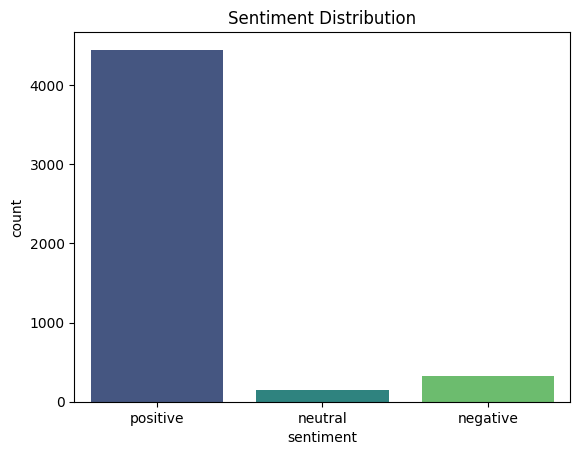

In [6]:
#Class Distribution (Check imbalance)
sns.countplot(data=df, x="sentiment", palette="viridis")
plt.title("Sentiment Distribution")
plt.show()

This bar chart shows a heavily imbalanced dataset, with a very high number of 'positive' reviews (around 4400), a much smaller

number of 'negative' reviews (around 300), and even fewer 'neutral' reviews (around 140).

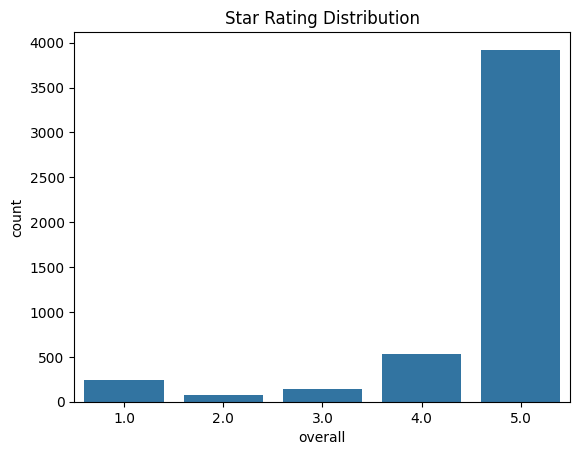

In [7]:
#Rating Distribution
sns.countplot(data=df, x="overall")
plt.title("Star Rating Distribution")
plt.show()

This chart reveals that most reviews are 5-star ratings, followed by 4-star ratings. There are significantly fewer 1, 2, and 3-

star ratings, confirming the positive skew in the 'overall' ratings.

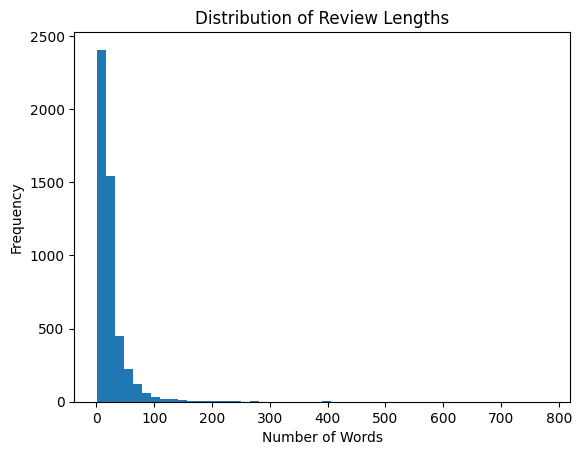

In [8]:
#Text Length Distribution
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))

plt.hist(df["text_length"], bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


The histogram indicates that most cleaned reviews are relatively short, with the majority having fewer than 50 words. There's a

long tail indicating some longer reviews, but they are less frequent

**Most Common Words**

**Unigrams**:**bold text**

In [9]:
from collections import Counter
all_words = " ".join(df["clean_text"]).split()
word_freq = Counter(all_words).most_common(20)
word_freq


[('card', 5537),
 ('work', 2044),
 ('phone', 1909),
 ('gb', 1756),
 ('great', 1446),
 ('memory', 1378),
 ('sandisk', 1286),
 ('sd', 1209),
 ('one', 1120),
 ('use', 1115),
 ('galaxy', 1025),
 ('speed', 924),
 ('fast', 907),
 ('good', 891),
 ('price', 882),
 ('problem', 848),
 ('bought', 832),
 ('samsung', 828),
 ('storage', 756),
 ('tablet', 726)]

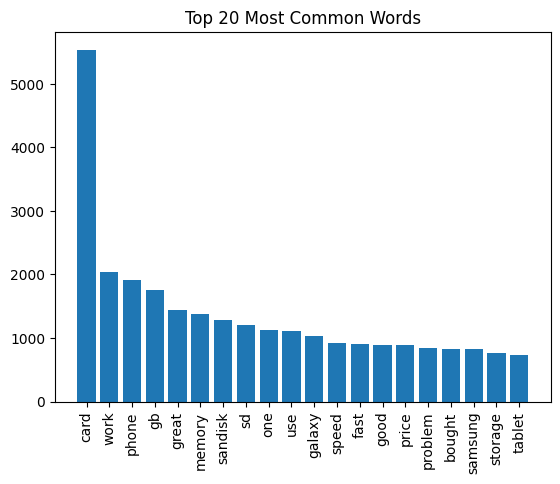

In [10]:
# create a bar chart
words, freq = zip(*word_freq)
plt.bar(words, freq)
plt.xticks(rotation=90)
plt.title("Top 20 Most Common Words")
plt.show()


The bar chart based on word_freq lists the 20 most frequent words after cleaning and lemmatization. Words like 'card', 'work',

'phone', 'gb', 'great', and 'memory' are highly prominent, suggesting the reviews are largely about storage devices and mobile

phones.

## Bigrams and  Trigrams

In [11]:
from nltk import ngrams

def get_top_ngrams(text, n=2, top=20):
    tokens = text.split()
    ngram_list = ngrams(tokens, n)
    return Counter(ngram_list).most_common(top)

bigrams = get_top_ngrams(" ".join(df["clean_text"]), n=2)
trigrams = get_top_ngrams(" ".join(df["clean_text"]), n=3)

bigrams[:10], trigrams[:10]


([(('sd', 'card'), 830),
  (('memory', 'card'), 668),
  (('work', 'great'), 510),
  (('samsung', 'galaxy'), 478),
  (('micro', 'sd'), 357),
  (('galaxy', 'note'), 273),
  (('gb', 'card'), 260),
  (('microsd', 'card'), 238),
  (('card', 'work'), 227),
  (('work', 'well'), 193)],
 [(('micro', 'sd', 'card'), 217),
  (('samsung', 'galaxy', 'note'), 119),
  (('sandisk', 'ultra', 'gb'), 66),
  (('samsung', 'galaxy', 'tab'), 52),
  (('card', 'work', 'great'), 52),
  (('memory', 'card', 'work'), 50),
  (('gb', 'micro', 'sd'), 49),
  (('galaxy', 'note', 'ii'), 44),
  (('new', 'samsung', 'galaxy'), 37),
  (('use', 'samsung', 'galaxy'), 37)])

The output shows common two-word (bigrams) and three-word (trigrams) phrases. For example, 'sd card', 'memory card', and 'work

great' are frequent bigrams, while 'micro sd card' and 'samsung galaxy note' are common trigrams. This further highlights the

product categories and common user sentiments/experiences.

## Correlation Heatmap (Numerical features)

This box plot illustrates how the length of reviews (number of words) is distributed across different sentiment categories (positive, neutral, negative).

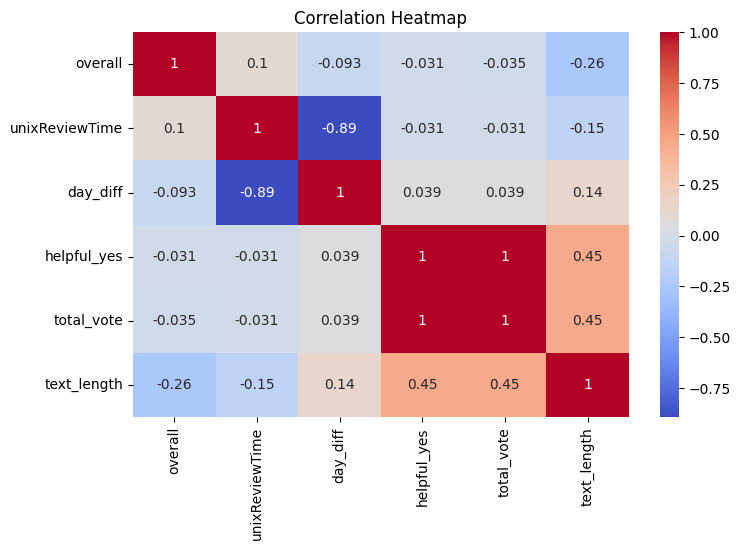

In [12]:
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(8,5))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


This heatmap displays the correlation coefficients between numerical features. It helps identify relationships between

variables like overall rating, day_diff, helpful_yes, total_vote, and text_length. Positive values indicate a positive

correlation, negative values a negative correlation, and values close to zero indicate weak or no linear correlation.

## Sentiment by Review Length

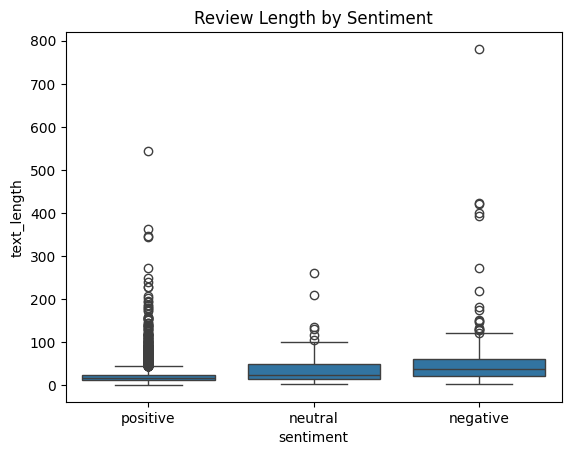

In [13]:
sns.boxplot(data=df, x="sentiment", y="text_length")
plt.title("Review Length by Sentiment")
plt.show()


This heatmap displays the correlation coefficients between numerical features. It helps identify relationships between

variables like overall rating, day_diff, helpful_yes, total_vote, and text_length. Positive values indicate a positive

correlation, negative values a negative correlation, and values close to zero indicate weak or no linear correlation.

## Word Clouds for Positive vs Negative

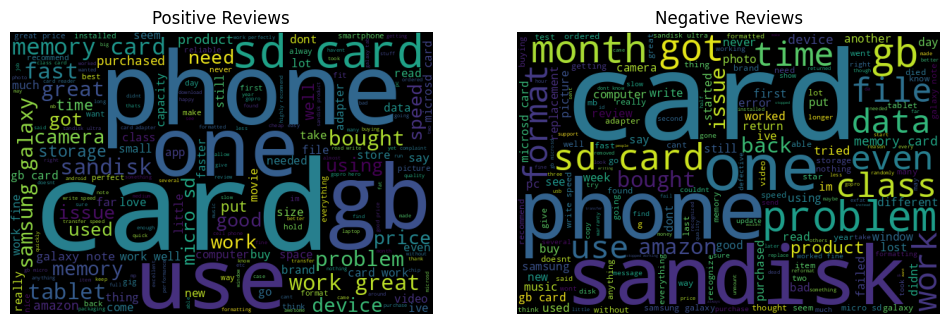

In [14]:
from wordcloud import WordCloud

positive_words = " ".join(df[df["sentiment"]=="positive"]["clean_text"])
negative_words = " ".join(df[df["sentiment"]=="negative"]["clean_text"])

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400).generate(positive_words))
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(negative_words))
plt.axis("off")
plt.title("Negative Reviews")

plt.show()


These visual representations highlight the most frequent words in positive and negative reviews. Larger words indicate higher

frequency. This gives a quick qualitative insight into the vocabulary used for different sentiment expressions (e.g., 'great',

'love' for positive vs. 'problem', 'bad' for negative).